In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [3]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [5]:
import IPython.display as display
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
import pathlib
import random
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import numpy as np
import rasterio
from rasterio.plot import show
import os
from tifffile import imread
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn import preprocessing
from keras.layers import Dropout, Conv1D, Conv2D, MaxPool2D, Flatten,BatchNormalization,Activation, Input, ZeroPadding2D, MaxPooling2D, Add
from keras.layers import AveragePooling2D
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from keras.initializers import glorot_uniform

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

## Import images from google drive

In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#cd '/gdrive/My Drive/tiles8x8_rgbnirndvimax'

/gdrive/My Drive/tiles8x8_rgbnirndvimax


## Load and Preprocess the Images

In [7]:
def read_data(directory):
    X = []
    y = []
    for species in os.listdir(directory):
      #if species != "hackberry" and species != "ashe juniper" and species != "crape myrtle" and species != "escarpment live oak":
        print(species)
        if not species.startswith('.'):
            for i in os.listdir(directory + '/' + species):
                if not i.startswith('.'):
                    f = os.path.join(directory, species, i)
                    img = imread(f)
                    b0 = img[0]
                    b1 = img[1]
                    b2 = img[2]
                    b3 = img[3]
                    b4 = img[4]
                    b5 = img[5]
                    b6 = img[6]
                    b7 = img[7]
                    b8 = img[8]
                    b9 = img[9]
                    arr = np.stack((b0, b1, b2, b3, b4, b5, b6, b7, b8, b9), axis=2)
                    #arr = rasterio.open(f).read()
                    label = species
                    X.append(arr)
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    print(X.shape, y.shape)
    return X, y

X, y = read_data("tiles8x8_rgbnirndvimax")

ashe
southern
elm
pecan
hackberry
escarpment
crape
(37541, 8, 8, 10) (37541,)


In [8]:
# summarize class distribution
counter = Counter(y)
print(counter)

Counter({'pecan': 10217, 'elm': 8354, 'southern': 8135, 'escarpment': 5529, 'crape': 2308, 'hackberry': 1860, 'ashe': 1138})


In [9]:
# transform the dataset
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X.reshape(X.shape[0],-1), y)
# summarize the new class distribution
counter_sm = Counter(y_sm)
print(counter_sm)

Counter({'ashe': 10217, 'southern': 10217, 'elm': 10217, 'pecan': 10217, 'hackberry': 10217, 'escarpment': 10217, 'crape': 10217})


In [10]:
X_sm = X_sm.reshape(X_sm.shape[0],8,8,10)
print(X_sm.shape)

(71519, 8, 8, 10)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=0)
print('The shape for each set is:', X_train.shape, X_test.shape, y_train.shape, y_test.shape )

The shape for each set is: (57215, 8, 8, 10) (14304, 8, 8, 10) (57215,) (14304,)


In [12]:
#Label Encode
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [13]:
label_encoder.classes_

array(['ashe', 'crape', 'elm', 'escarpment', 'hackberry', 'pecan',
       'southern'], dtype='<U10')

In [14]:
X_train /= 255
X_test /= 255

## Baseline Model

In [16]:
model = Sequential()

model.add(Conv2D(32, 3, padding='same', input_shape=(8,8,10)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(1,1)))

model.add(Conv2D(128, 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(1,1)))

#model.add(Conv2D(256, 3, padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPool2D(pool_size=(1,1)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.25))


model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 32)          2912      
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 32)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)        

In [17]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)

In [19]:
sgd = tf.keras.optimizers.SGD(lr=0.01)
metrics=['accuracy']

model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=metrics)
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=50, validation_data=(X_test, y_test_encoded),callbacks=[model_checkpoint_callback])

Epoch 1/50


/Users/cyndichen/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


447/447 [==============================] - 55s 121ms/step - loss: 1.7863 - accuracy: 0.2786 - val_loss: 2.4146 - val_accuracy: 0.1688
Epoch 2/50
447/447 [==============================] - 59s 133ms/step - loss: 1.6042 - accuracy: 0.3745 - val_loss: 1.6894 - val_accuracy: 0.3292
Epoch 3/50
447/447 [==============================] - 57s 129ms/step - loss: 1.4954 - accuracy: 0.4274 - val_loss: 1.4480 - val_accuracy: 0.4506
Epoch 4/50
447/447 [==============================] - 52s 115ms/step - loss: 1.4021 - accuracy: 0.4690 - val_loss: 1.6543 - val_accuracy: 0.3979
Epoch 5/50
447/447 [==============================] - 51s 115ms/step - loss: 1.3194 - accuracy: 0.5078 - val_loss: 2.1363 - val_accuracy: 0.2747
Epoch 6/50
447/447 [==============================] - 54s 120ms/step - loss: 1.2416 - accuracy: 0.5378 - val_loss: 1.2461 - val_accuracy: 0.5268
Epoch 7/50
447/447 [==============================] - 55s 124ms/step - loss: 1.1650 - accuracy: 0.5697 - val_loss: 1.3725 - val_accuracy: 0.4

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
score_test = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test loss: {score_test[0]} / Test accuracy: {score_test[1]}')

Test loss: 0.9625751376152039 / Test accuracy: 0.7468540072441101


In [21]:
y_test_pred = np.argmax(model.predict(X_test),axis=1)
y_test_pred

array([6, 1, 5, ..., 4, 3, 2])

In [22]:
cohen_kappa_score(y_test_encoded, y_test_pred)

0.7046124298455873

In [23]:
target_names = label_encoder.classes_.tolist()
print(classification_report(y_test_encoded, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

        ashe       0.93      0.98      0.96      2053
       crape       0.87      0.89      0.88      2113
         elm       0.64      0.63      0.64      2045
  escarpment       0.66      0.71      0.69      2069
   hackberry       0.93      0.89      0.91      2046
       pecan       0.55      0.52      0.53      1988
    southern       0.60      0.59      0.60      1990

    accuracy                           0.75     14304
   macro avg       0.74      0.74      0.74     14304
weighted avg       0.74      0.75      0.75     14304



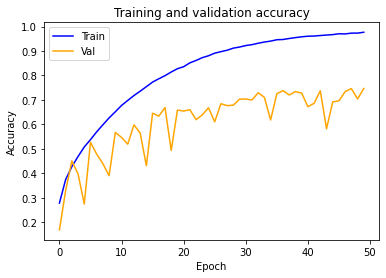

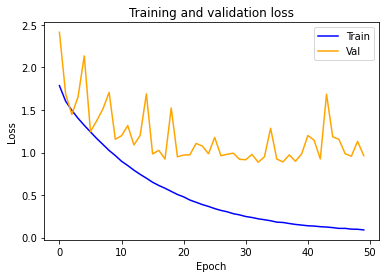

In [24]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)

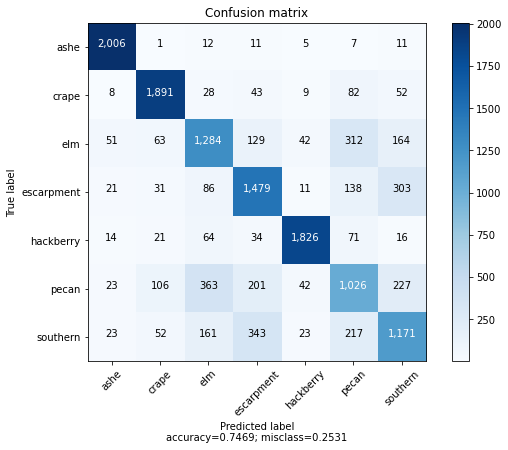

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
conf_mat = confusion_matrix(y_test_encoded, y_test_pred, labels=[0,1,2,3,4,5,6,])

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(conf_mat,
                      target_names,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=False)

## Resnet34 

In [46]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [47]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [48]:
def ResNet34(shape = (8, 8, 10), classes = 7, filter_size=16):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(filter_size, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

## Build ResNet34 Model (train-test)

In [58]:
# Initialize and compile model
model2 = ResNet34()
model2.compile(loss=keras.losses.SparseCategoricalCrossentropy(),\
               optimizer=tf.keras.optimizers.SGD(lr=0.01),\
               metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 8, 8, 10)]   0           []                               
                                                                                                  
 zero_padding2d_9 (ZeroPadding2  (None, 14, 14, 10)  0           ['input_10[0][0]']               
 D)                                                                                               
                                                                                                  
 conv2d_324 (Conv2D)            (None, 7, 7, 16)     7856        ['zero_padding2d_9[0][0]']       
                                                                                                  
 batch_normalization_297 (Batch  (None, 7, 7, 16)    64          ['conv2d_324[0][0]']      

                                                                  'conv2d_333[0][0]']             
                                                                                                  
 activation_305 (Activation)    (None, 2, 2, 32)     0           ['add_147[0][0]']                
                                                                                                  
 conv2d_334 (Conv2D)            (None, 2, 2, 32)     9248        ['activation_305[0][0]']         
                                                                                                  
 batch_normalization_306 (Batch  (None, 2, 2, 32)    128         ['conv2d_334[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_306 (Activation)    (None, 2, 2, 32)     0           ['batch_normalization_306[0][0]']
          

 batch_normalization_315 (Batch  (None, 1, 1, 64)    256         ['conv2d_344[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_152 (Add)                  (None, 1, 1, 64)     0           ['batch_normalization_315[0][0]',
                                                                  'activation_313[0][0]']         
                                                                                                  
 activation_315 (Activation)    (None, 1, 1, 64)     0           ['add_152[0][0]']                
                                                                                                  
 conv2d_345 (Conv2D)            (None, 1, 1, 64)     36928       ['activation_315[0][0]']         
                                                                                                  
 batch_nor

 conv2d_354 (Conv2D)            (None, 1, 1, 128)    147584      ['activation_324[0][0]']         
                                                                                                  
 batch_normalization_325 (Batch  (None, 1, 1, 128)   512         ['conv2d_354[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_355 (Conv2D)            (None, 1, 1, 128)    8320        ['activation_323[0][0]']         
                                                                                                  
 add_157 (Add)                  (None, 1, 1, 128)    0           ['batch_normalization_325[0][0]',
                                                                  'conv2d_355[0][0]']             
                                                                                                  
 activatio

In [59]:
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                            monitor='val_accuracy',
                                                            mode='max',
                                                            save_best_only=True)

In [60]:
history2 = model2.fit(X_train, y_train_encoded, 
                      batch_size=512, epochs=200, 
                      validation_data=(X_test, y_test_encoded),
                      callbacks=[model_checkpoint_callback])

Epoch 1/200
112/112 [==============================] - 21s 164ms/step - loss: 2.1985 - accuracy: 0.1622 - val_loss: 1.9476 - val_accuracy: 0.1438
Epoch 2/200
112/112 [==============================] - 18s 162ms/step - loss: 1.9635 - accuracy: 0.1933 - val_loss: 1.9517 - val_accuracy: 0.1509
Epoch 3/200
112/112 [==============================] - 18s 159ms/step - loss: 1.8964 - accuracy: 0.2164 - val_loss: 1.9948 - val_accuracy: 0.1477
Epoch 4/200
112/112 [==============================] - 18s 156ms/step - loss: 1.8466 - accuracy: 0.2414 - val_loss: 2.0317 - val_accuracy: 0.1618
Epoch 5/200
112/112 [==============================] - 17s 155ms/step - loss: 1.7939 - accuracy: 0.2665 - val_loss: 2.1131 - val_accuracy: 0.1748
Epoch 6/200
112/112 [==============================] - 17s 153ms/step - loss: 1.7498 - accuracy: 0.2860 - val_loss: 1.8585 - val_accuracy: 0.2458
Epoch 7/200
112/112 [==============================] - 17s 155ms/step - loss: 1.7158 - accuracy: 0.3077 - val_loss: 1.7215 -

Epoch 57/200
112/112 [==============================] - 17s 151ms/step - loss: 1.0962 - accuracy: 0.5834 - val_loss: 1.6543 - val_accuracy: 0.4065
Epoch 58/200
112/112 [==============================] - 17s 150ms/step - loss: 1.0814 - accuracy: 0.5888 - val_loss: 1.7854 - val_accuracy: 0.3826
Epoch 59/200
112/112 [==============================] - 17s 151ms/step - loss: 1.0714 - accuracy: 0.5934 - val_loss: 1.7056 - val_accuracy: 0.4042
Epoch 60/200
112/112 [==============================] - 17s 151ms/step - loss: 1.0684 - accuracy: 0.5954 - val_loss: 1.6672 - val_accuracy: 0.4103
Epoch 61/200
112/112 [==============================] - 18s 158ms/step - loss: 1.0623 - accuracy: 0.5967 - val_loss: 1.4741 - val_accuracy: 0.4750
Epoch 62/200
112/112 [==============================] - 18s 157ms/step - loss: 1.0526 - accuracy: 0.6026 - val_loss: 1.4675 - val_accuracy: 0.4657
Epoch 63/200
112/112 [==============================] - 17s 152ms/step - loss: 1.0540 - accuracy: 0.6004 - val_loss: 1

112/112 [==============================] - 19s 166ms/step - loss: 0.5668 - accuracy: 0.7908 - val_loss: 1.6350 - val_accuracy: 0.5223
Epoch 168/200
112/112 [==============================] - 19s 166ms/step - loss: 0.5455 - accuracy: 0.7983 - val_loss: 1.9414 - val_accuracy: 0.4745
Epoch 169/200
112/112 [==============================] - 19s 172ms/step - loss: 0.5653 - accuracy: 0.7916 - val_loss: 1.6945 - val_accuracy: 0.5151
Epoch 170/200
112/112 [==============================] - 19s 172ms/step - loss: 0.5187 - accuracy: 0.8099 - val_loss: 1.7841 - val_accuracy: 0.5064
Epoch 171/200
112/112 [==============================] - 18s 161ms/step - loss: 0.5585 - accuracy: 0.7947 - val_loss: 1.7062 - val_accuracy: 0.4989
Epoch 172/200
112/112 [==============================] - 18s 159ms/step - loss: 0.5324 - accuracy: 0.8019 - val_loss: 1.6700 - val_accuracy: 0.5261
Epoch 173/200
112/112 [==============================] - 18s 164ms/step - loss: 0.5415 - accuracy: 0.7998 - val_loss: 1.6397 -

Metrics: 
1. 7 species: recall, precision, f-1
2. Overall accuracy
3. Cohen kappa’s coefficient


In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score

In [61]:
score_test = model2.evaluate(X_test, y_test_encoded, verbose=0)
print(f'Test loss: {score_test[0]} / Test accuracy: {score_test[1]}')

Test loss: 1.667850375175476 / Test accuracy: 0.5506851077079773


In [62]:
score_train = model2.evaluate(X_train, y_train_encoded, verbose=0)
print(f'Train loss: {score_train[0]} / Train accuracy: {score_train[1]}')

Train loss: 0.7556132078170776 / Train accuracy: 0.7406100034713745


### threshold the probability

In [63]:
y_test_pred = np.argmax(model2.predict(X_test),axis=1)
y_test_pred

array([1, 1, 2, ..., 4, 6, 2])

In [147]:
model2.predict(X_test)[0]

array([0.00225838, 0.3706895 , 0.24436903, 0.01550743, 0.00100485,
       0.29035878, 0.07581202], dtype=float32)

In [148]:
sum(model2.predict(X_test)[0]<0.2)

4

In [145]:
#threshold the probability (not include prob less than 20)
pred = model2.predict(X_test)
classes = [7 if sum(p<0.2)==7 else np.argmax(p) for p in pred] 
classes

[1,
 1,
 2,
 0,
 3,
 1,
 5,
 2,
 5,
 5,
 1,
 3,
 3,
 1,
 5,
 4,
 3,
 6,
 1,
 6,
 0,
 4,
 3,
 4,
 2,
 5,
 6,
 1,
 3,
 2,
 6,
 4,
 4,
 6,
 6,
 4,
 4,
 4,
 1,
 5,
 3,
 3,
 2,
 4,
 0,
 4,
 0,
 1,
 4,
 0,
 6,
 3,
 2,
 1,
 0,
 6,
 1,
 0,
 4,
 3,
 5,
 3,
 3,
 6,
 2,
 5,
 4,
 1,
 4,
 4,
 4,
 6,
 5,
 6,
 6,
 2,
 1,
 4,
 2,
 6,
 4,
 1,
 5,
 6,
 3,
 5,
 2,
 5,
 5,
 6,
 5,
 0,
 4,
 5,
 2,
 0,
 5,
 6,
 2,
 4,
 4,
 2,
 0,
 6,
 6,
 3,
 3,
 4,
 0,
 4,
 1,
 5,
 0,
 5,
 5,
 5,
 1,
 1,
 3,
 0,
 0,
 4,
 4,
 4,
 2,
 2,
 4,
 3,
 2,
 0,
 4,
 1,
 3,
 2,
 3,
 6,
 5,
 6,
 3,
 4,
 5,
 0,
 4,
 4,
 4,
 6,
 3,
 4,
 0,
 5,
 1,
 0,
 1,
 1,
 0,
 4,
 4,
 5,
 4,
 2,
 6,
 0,
 3,
 5,
 1,
 2,
 1,
 6,
 6,
 1,
 3,
 3,
 1,
 5,
 0,
 4,
 4,
 5,
 2,
 0,
 2,
 1,
 0,
 5,
 1,
 1,
 4,
 3,
 5,
 0,
 3,
 0,
 0,
 2,
 1,
 1,
 4,
 6,
 5,
 1,
 4,
 0,
 5,
 1,
 2,
 1,
 0,
 0,
 6,
 6,
 1,
 2,
 4,
 6,
 5,
 5,
 2,
 2,
 6,
 1,
 6,
 6,
 6,
 5,
 3,
 4,
 3,
 0,
 2,
 0,
 1,
 4,
 6,
 0,
 2,
 2,
 4,
 5,
 5,
 1,
 6,
 0,
 1,
 0,
 5,
 5,
 5,
 4,
 4,
 3,


In [146]:
print(Counter(classes))

Counter({4: 2830, 5: 2066, 0: 1995, 6: 1970, 1: 1945, 2: 1796, 3: 1702})


In [149]:
#threshold the probability (not include prob less than 30)
classes2 = [7 if sum(p<0.3)==7 else np.argmax(p) for p in pred] 
print(Counter(classes2))

Counter({4: 2823, 5: 2055, 0: 1991, 6: 1960, 1: 1941, 2: 1776, 3: 1687, 7: 71})


### Continue the evaluation

In [64]:
cohen_kappa_score(y_test_encoded, y_test_pred)

0.47583438790628374

In [65]:
target_names = label_encoder.classes_.tolist()
print(classification_report(y_test_encoded, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

        ashe       0.83      0.80      0.81      2053
       crape       0.69      0.64      0.66      2113
         elm       0.44      0.39      0.41      2045
  escarpment       0.52      0.43      0.47      2069
   hackberry       0.59      0.82      0.69      2046
       pecan       0.36      0.37      0.36      1988
    southern       0.41      0.40      0.40      1990

    accuracy                           0.55     14304
   macro avg       0.55      0.55      0.54     14304
weighted avg       0.55      0.55      0.55     14304



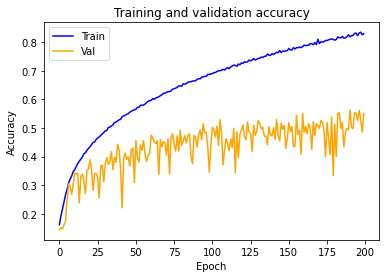

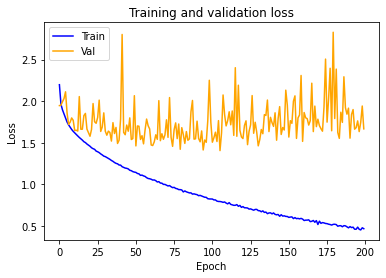

In [66]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history2)

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
conf_mat = confusion_matrix(y_test_encoded, y_test_pred, labels=[0,1,2,3,4,5,6,])

#ax = sns.heatmap(conf_mat, cmap="Blues",square=True, cbar=False, annot=True)
#ax.set_title("Confusion Matrix")
#ax.set_xlabel("Predicted")
#ax.set_ylabel("Actual")
#ax.set_yticklabels(['elm', 'escarpment', 'pecan', 'southern'])
#ax.set_xticklabels(['elm', 'escarpment', 'pecan', 'southern'])

In [68]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

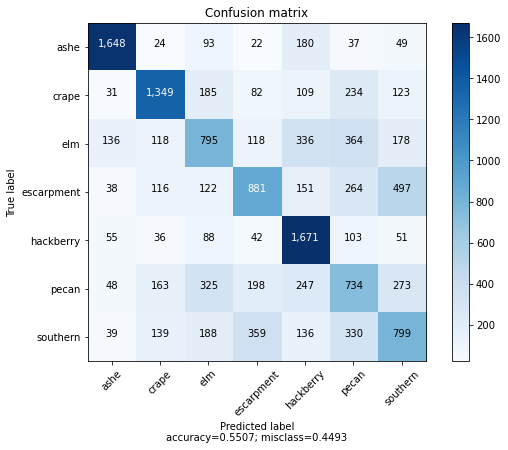

In [69]:
plot_confusion_matrix(conf_mat,
                      target_names,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=False)